In [1]:
import pickle
import math
import random

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime as dt

from web_crawler import grabDomainRoot

'''
randomWalk(graph, initial_node, step, max_step, path)

Function to take a random walk from a given node

graph: networkx graph, graph from which to random through
initial node: string, initial node to begin the walk
step: int, current step of walk
max_step: int, maximum number of steps to take in walk
path:, list, current path taken in the walk
'''
def randomWalk(graph, initial_node, step, max_step, path):
 
    if step>= max_step: 
        return path
    
    adjacent_nodes = [i for i in graph.neighbors(initial_node)]
    
    next_node = random.sample(adjacent_nodes, 1)[0]
    
    path.append(next_node)
    
    return randomWalk(graph, next_node, step+1, max_step, path)

'''
generateBatch(batch_size, num_context_per_label, context_window, target, step)

batch_size: int, batch size for training
num_context_per_label: int, how many context examples to use per label (the label is the target) 
can't be greater than the context window size
context_window: int, size of the context window 
target: array, the list of targets for each context window
step: int, counter for how many times to step through the same context and target data

Generate the batch data for training. For each "context window", randomly sample a
set of context elements and configure them as training data by constructing column data of,

[target_0, context_0]
[target_0, context_1]
[target_0, context_3]
...
[target_n, context_3]
[target_n, context_2]
[target_n, context_1]

'''
def generateBatch(batch_size, num_context_per_label, context_window, target, step):

    batch = []
    passes_through_batch = batch_size//num_context_per_label
    
    for window_idx in range(passes_through_batch):

        current_window = list(context_window[window_idx + passes_through_batch*step])
        current_target = target[window_idx + passes_through_batch*step]
        context_samples = random.sample(current_window, num_context_per_label)
        data_samples =  [[context_sample, [current_target]] for context_sample in context_samples]

        for data_sample in data_samples:
            batch.append(data_sample)
            
    return batch

black_list = ['@', ':/']

In [2]:
graph_file = pickle.load(open('crawler_results/graph_calls_620000_stack_test.pkl', 'rb'))

In [10]:
#Create a graph out of the connections

#web_graph = nx.DiGraph()
web_graph = nx.Graph()
for node in graph_file.keys():
    for idx in range(0, len(graph_file[node]), 3):
        key = graph_file[node][idx]

        domain_node = grabDomainRoot(node)
        domain_key = grabDomainRoot(key)
        
        if domain_node is None or domain_key is None: 
            continue
        if True in [i in domain_node for i in black_list] or True in [i in domain_key for i in black_list]:
            continue

        web_graph.add_edge(domain_node, domain_key)

NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL
NO BASE URL


In [11]:
list_of_nodes = [i for i in web_graph.nodes()]

In [54]:
domain_inv_map = {idx:i for idx, i in enumerate(list_of_nodes)}
domain_map = {i:idx for idx, i in enumerate(list_of_nodes)}

In [15]:
#Sanity check
#print('%d nodes, %d dict terms, %d key_domain dict' % (len(list_of_nodes), len(vocab_dict), len(key_domain_dict)))
print('%d nodes, %d key_domain dict' % (len(list_of_nodes), len(domain_inv_map)))

8943 nodes, 8943 key_domain dict


In [33]:
max_step = 4# Window size and max_step must be connected

num_skips = 2 #The number of context examples per label to create x-y data out of 
#i.e. the number of rows of "data" per window, label combo
window_size = max_step//2 #where max step must be even
embedding_size = 32  #Dimension of the embedding vector.
vocabulary_size = len(web_graph.nodes())

num_sampled = 64 #Number of negative examples to sample. 
#As this number goes to the total number of samples it reproduces softmax, 
#this not quite correct as we still doing binary classification, except now we give every negative example to test against,
#as opposed to true multi-class classification
batch_size = 64 #must be a multiple of num_skips
num_steps = int(len(list_of_nodes)/batch_size)
n_epochs = 10000 #This controls the number of walks from each node

In [35]:
print ('%d nodes, %d steps per epoch' % (len(list_of_nodes), num_steps))

8943 nodes, 139 steps per epoch


In [36]:
tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm

In [45]:
avg_loss_record = []
list_batch_labels = []
list_batch_inputs = []

with tf.Session(graph=graph) as session:

    session.run(tf.global_variables_initializer())
    print('Initialized')

    average_loss = 0

    for epoch in range(n_epochs):
        #Shuffle the list of nodes at the start of each epoch
        random.shuffle(list_of_nodes)
        random_walks = []
        
        for node in list_of_nodes:
            #Step through each node and conduct a random walk about it of length max_step
            path = randomWalk(web_graph, node, 0, max_step, [node])
            
            path = [domain_map[i] for i in path]
            random_walks.append(path)
        
        data_windows = np.array(random_walks)
                
        target = data_windows[:,window_size]

        left_window = data_windows[:,:window_size]

        right_window = data_windows[:,window_size+1:]

        context_window = np.concatenate([left_window, right_window], axis=1)
            
        for step in range(num_steps):

            batch_data = generateBatch(batch_size, num_skips, context_window, target, step)
            batch_inputs = [row[0] for row in batch_data]
            batch_labels = [row[1] for row in batch_data]
           
            feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
            list_batch_labels.append([batch_labels])
            list_batch_inputs.append([batch_inputs])
            
            _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
            
            average_loss += loss_val
         
        if epoch%1==0: 
            
            avg_loss_record.append(float(average_loss)/num_steps)
            print('epoch:%d, Average loss:%.7g' % (epoch, float(average_loss)/num_steps))
        
        average_loss = 0

        final_embeddings = normalized_embeddings.eval()

Initialized
epoch:0, Average loss:201.0651
epoch:1, Average loss:180.1612
epoch:2, Average loss:167.784
epoch:3, Average loss:161.2119
epoch:4, Average loss:152.6324
epoch:5, Average loss:142.3703
epoch:6, Average loss:138.4955
epoch:7, Average loss:129.1191
epoch:8, Average loss:124.9444
epoch:9, Average loss:119.9018
epoch:10, Average loss:115.8541
epoch:11, Average loss:108.5474
epoch:12, Average loss:106.3352
epoch:13, Average loss:99.02678
epoch:14, Average loss:94.69514
epoch:15, Average loss:91.58173
epoch:16, Average loss:88.32408
epoch:17, Average loss:86.52755
epoch:18, Average loss:81.67401
epoch:19, Average loss:77.82794
epoch:20, Average loss:75.2215
epoch:21, Average loss:71.08004
epoch:22, Average loss:68.647
epoch:23, Average loss:66.9712
epoch:24, Average loss:64.81722
epoch:25, Average loss:62.66742
epoch:26, Average loss:59.60324
epoch:27, Average loss:58.72591
epoch:28, Average loss:54.34379
epoch:29, Average loss:54.64056
epoch:30, Average loss:50.70596
epoch:31, A

epoch:253, Average loss:3.536277
epoch:254, Average loss:3.611324
epoch:255, Average loss:3.625783
epoch:256, Average loss:3.520257
epoch:257, Average loss:3.634608
epoch:258, Average loss:3.579152
epoch:259, Average loss:3.566695
epoch:260, Average loss:3.531519
epoch:261, Average loss:3.497372
epoch:262, Average loss:3.523329
epoch:263, Average loss:3.452744
epoch:264, Average loss:3.496967
epoch:265, Average loss:3.485909
epoch:266, Average loss:3.505375
epoch:267, Average loss:3.49231
epoch:268, Average loss:3.567245
epoch:269, Average loss:3.45723
epoch:270, Average loss:3.503774
epoch:271, Average loss:3.420156
epoch:272, Average loss:3.492
epoch:273, Average loss:3.461158
epoch:274, Average loss:3.519635
epoch:275, Average loss:3.473402
epoch:276, Average loss:3.456997
epoch:277, Average loss:3.413737
epoch:278, Average loss:3.47703
epoch:279, Average loss:3.443362
epoch:280, Average loss:3.42652
epoch:281, Average loss:3.484167
epoch:282, Average loss:3.458219
epoch:283, Averag

epoch:503, Average loss:2.969147
epoch:504, Average loss:2.92428
epoch:505, Average loss:2.936592
epoch:506, Average loss:2.977297
epoch:507, Average loss:2.95936
epoch:508, Average loss:2.978122
epoch:509, Average loss:2.908093
epoch:510, Average loss:2.932312
epoch:511, Average loss:2.939285
epoch:512, Average loss:2.964261
epoch:513, Average loss:2.876209
epoch:514, Average loss:2.9291
epoch:515, Average loss:2.943052
epoch:516, Average loss:2.922459
epoch:517, Average loss:2.903786
epoch:518, Average loss:2.937923
epoch:519, Average loss:2.951805
epoch:520, Average loss:2.875827
epoch:521, Average loss:2.936041
epoch:522, Average loss:2.877187
epoch:523, Average loss:2.87695
epoch:524, Average loss:2.861285
epoch:525, Average loss:2.905636
epoch:526, Average loss:2.916723
epoch:527, Average loss:2.902006
epoch:528, Average loss:2.920549
epoch:529, Average loss:2.899446
epoch:530, Average loss:2.870859
epoch:531, Average loss:2.899411
epoch:532, Average loss:2.935432
epoch:533, Aver

epoch:753, Average loss:2.705233
epoch:754, Average loss:2.656785
epoch:755, Average loss:2.7173
epoch:756, Average loss:2.66298
epoch:757, Average loss:2.665103
epoch:758, Average loss:2.641633
epoch:759, Average loss:2.692214
epoch:760, Average loss:2.710087
epoch:761, Average loss:2.661892
epoch:762, Average loss:2.715034
epoch:763, Average loss:2.635388
epoch:764, Average loss:2.698218
epoch:765, Average loss:2.68229
epoch:766, Average loss:2.678867
epoch:767, Average loss:2.667302
epoch:768, Average loss:2.632492
epoch:769, Average loss:2.652424
epoch:770, Average loss:2.61101
epoch:771, Average loss:2.618566
epoch:772, Average loss:2.693602
epoch:773, Average loss:2.69277
epoch:774, Average loss:2.655165
epoch:775, Average loss:2.693408
epoch:776, Average loss:2.6534
epoch:777, Average loss:2.696608
epoch:778, Average loss:2.671868
epoch:779, Average loss:2.65923
epoch:780, Average loss:2.70295
epoch:781, Average loss:2.669515
epoch:782, Average loss:2.632166
epoch:783, Average l

epoch:1003, Average loss:2.464737
epoch:1004, Average loss:2.485803
epoch:1005, Average loss:2.487614
epoch:1006, Average loss:2.566159
epoch:1007, Average loss:2.500508
epoch:1008, Average loss:2.462932
epoch:1009, Average loss:2.520467
epoch:1010, Average loss:2.462524
epoch:1011, Average loss:2.459479
epoch:1012, Average loss:2.506872
epoch:1013, Average loss:2.553766
epoch:1014, Average loss:2.498054
epoch:1015, Average loss:2.476731
epoch:1016, Average loss:2.455862
epoch:1017, Average loss:2.496322
epoch:1018, Average loss:2.487577
epoch:1019, Average loss:2.477568
epoch:1020, Average loss:2.456278
epoch:1021, Average loss:2.471287
epoch:1022, Average loss:2.464497
epoch:1023, Average loss:2.482422
epoch:1024, Average loss:2.482031
epoch:1025, Average loss:2.455089
epoch:1026, Average loss:2.467936
epoch:1027, Average loss:2.493954
epoch:1028, Average loss:2.48199
epoch:1029, Average loss:2.435489
epoch:1030, Average loss:2.461224
epoch:1031, Average loss:2.437852
epoch:1032, Ave

epoch:1245, Average loss:2.34594
epoch:1246, Average loss:2.279485
epoch:1247, Average loss:2.346515
epoch:1248, Average loss:2.337735
epoch:1249, Average loss:2.316196
epoch:1250, Average loss:2.357784
epoch:1251, Average loss:2.368098
epoch:1252, Average loss:2.349739
epoch:1253, Average loss:2.398829
epoch:1254, Average loss:2.315246
epoch:1255, Average loss:2.38472
epoch:1256, Average loss:2.403771
epoch:1257, Average loss:2.345105
epoch:1258, Average loss:2.268143
epoch:1259, Average loss:2.361316
epoch:1260, Average loss:2.286118
epoch:1261, Average loss:2.292104
epoch:1262, Average loss:2.380831
epoch:1263, Average loss:2.325817
epoch:1264, Average loss:2.278586
epoch:1265, Average loss:2.369328
epoch:1266, Average loss:2.343569
epoch:1267, Average loss:2.336793
epoch:1268, Average loss:2.330253
epoch:1269, Average loss:2.325107
epoch:1270, Average loss:2.373854
epoch:1271, Average loss:2.320316
epoch:1272, Average loss:2.338451
epoch:1273, Average loss:2.352674
epoch:1274, Aver

epoch:1487, Average loss:2.195945
epoch:1488, Average loss:2.260262
epoch:1489, Average loss:2.173374
epoch:1490, Average loss:2.309198
epoch:1491, Average loss:2.198625
epoch:1492, Average loss:2.191401
epoch:1493, Average loss:2.197743
epoch:1494, Average loss:2.18977
epoch:1495, Average loss:2.229483
epoch:1496, Average loss:2.223991
epoch:1497, Average loss:2.189849
epoch:1498, Average loss:2.16778
epoch:1499, Average loss:2.220552
epoch:1500, Average loss:2.222478
epoch:1501, Average loss:2.177549
epoch:1502, Average loss:2.135622
epoch:1503, Average loss:2.192788
epoch:1504, Average loss:2.167783
epoch:1505, Average loss:2.246369
epoch:1506, Average loss:2.207463
epoch:1507, Average loss:2.214142
epoch:1508, Average loss:2.226386
epoch:1509, Average loss:2.279199
epoch:1510, Average loss:2.181338
epoch:1511, Average loss:2.201043
epoch:1512, Average loss:2.2031
epoch:1513, Average loss:2.195708
epoch:1514, Average loss:2.199139
epoch:1515, Average loss:2.173961
epoch:1516, Averag

epoch:1729, Average loss:2.043221
epoch:1730, Average loss:2.114908
epoch:1731, Average loss:2.049584
epoch:1732, Average loss:2.097385
epoch:1733, Average loss:2.064478
epoch:1734, Average loss:2.04194
epoch:1735, Average loss:2.025021
epoch:1736, Average loss:2.114099
epoch:1737, Average loss:2.100654
epoch:1738, Average loss:2.067178
epoch:1739, Average loss:2.062324
epoch:1740, Average loss:2.094278
epoch:1741, Average loss:2.06511
epoch:1742, Average loss:2.04076
epoch:1743, Average loss:2.061028
epoch:1744, Average loss:2.089282
epoch:1745, Average loss:2.039481
epoch:1746, Average loss:2.040233
epoch:1747, Average loss:2.011883
epoch:1748, Average loss:2.051713
epoch:1749, Average loss:2.086383
epoch:1750, Average loss:2.078602
epoch:1751, Average loss:2.022176
epoch:1752, Average loss:2.079159
epoch:1753, Average loss:2.024892
epoch:1754, Average loss:2.046606
epoch:1755, Average loss:2.125515
epoch:1756, Average loss:2.08002
epoch:1757, Average loss:2.123665
epoch:1758, Averag

epoch:1971, Average loss:1.948637
epoch:1972, Average loss:1.968299
epoch:1973, Average loss:1.926799
epoch:1974, Average loss:1.910455
epoch:1975, Average loss:1.933763
epoch:1976, Average loss:1.919452
epoch:1977, Average loss:1.964805
epoch:1978, Average loss:1.995504
epoch:1979, Average loss:2.008202
epoch:1980, Average loss:1.97159
epoch:1981, Average loss:1.956993
epoch:1982, Average loss:1.915902
epoch:1983, Average loss:2.054428
epoch:1984, Average loss:1.975965
epoch:1985, Average loss:1.946959
epoch:1986, Average loss:1.950882
epoch:1987, Average loss:1.950213
epoch:1988, Average loss:1.919876
epoch:1989, Average loss:1.968653
epoch:1990, Average loss:1.929878
epoch:1991, Average loss:1.914705
epoch:1992, Average loss:1.935561
epoch:1993, Average loss:2.000151
epoch:1994, Average loss:1.963167
epoch:1995, Average loss:1.912069
epoch:1996, Average loss:1.933824
epoch:1997, Average loss:1.966587
epoch:1998, Average loss:1.986151
epoch:1999, Average loss:1.949383
epoch:2000, Ave

KeyboardInterrupt: 

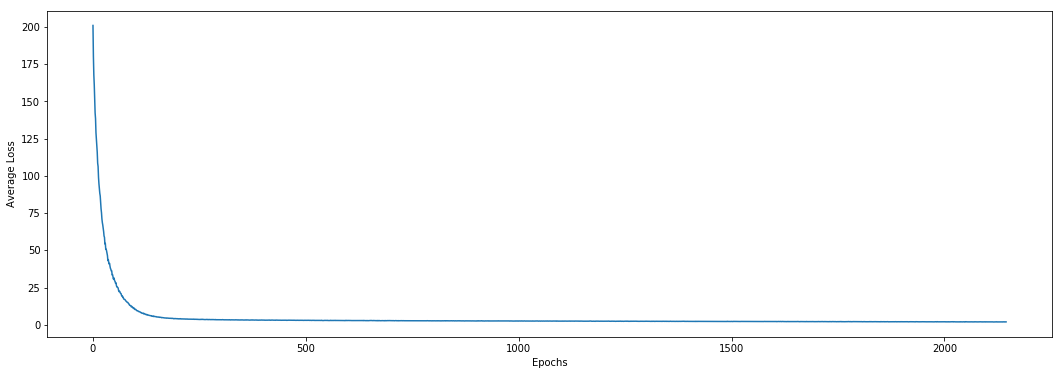

In [46]:
list_loss = np.array(avg_loss_record)
plt.figure(figsize=(18, 6))
plt.plot([i for 
          i in range(len(list_loss))], list_loss)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()

In [47]:
vector = tf.placeholder(dtype=tf.float32)

#Create cosine similarity matrix

mult_vector = tf.matmul(vector, vector, transpose_b=True)
sim_matrix = tf.acos(mult_vector)

In [48]:
with tf.Session() as sess:
    matrices = sess.run([sim_matrix, mult_vector] , feed_dict={vector:final_embeddings})

In [49]:
sim_matrix = matrices[0]

np.fill_diagonal(sim_matrix, 0)

In [53]:
pickle.dump(final_embeddings, open('embeddings_test_domain_graph_undirected.pkl', 'wb'))
pickle.dump(sim_matrix, open('cosine_matrix_test_domain_graph_undirected.pkl', 'wb'))
pickle.dump(domain_inv_map, open('domain_inv_map.pkl', 'wb'))